#Data Preparing

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('myproj').getOrCreate()
data = spark.read.csv('/FileStore/tables/traindata.csv',inferSchema=True,header=True)
data.printSchema()

root
-- id: integer (nullable = true)
-- Gender: string (nullable = true)
-- Age: integer (nullable = true)
-- Driving_License: integer (nullable = true)
-- Region_Code: double (nullable = true)
-- Previously_Insured: integer (nullable = true)
-- Vehicle_Age: string (nullable = true)
-- Vehicle_Damage: string (nullable = true)
-- Annual_Premium: double (nullable = true)
-- Policy_Sales_Channel: double (nullable = true)
-- Vintage: integer (nullable = true)
-- Response: integer (nullable = true)

In [0]:
# look at numerical values in a string column
data.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 1|
 2| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0|
 3| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 1|
 4| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0|
 5|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0|
 6|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0|
 7| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0|
 8|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 1|
 9|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0|
 10|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0|
 11|Female| 47| 1| 35.0| 0| 1-2 Year| Yes| 47576.0| 124.0| 46| 1|
 12|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289| 0|
 13|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221| 0|
 14| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| 0|
 15| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58| 0|
 16| Male| 37| 1| 6.0| 0| 1-2 Year| Yes| 2630.0| 156.0| 147| 1|
 17|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256| 0|
 18|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299| 0|
 19| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| 0|
 20|Female| 60| 1| 33.0| 0| 1-2 Year| Yes| 32363.0| 124.0| 102| 1|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
only showing top 20 rows

# Check Missing Value

In [0]:
# Check Missing Value
from pyspark.sql.functions import *
from pyspark.sql.functions import when, count, col
df = data.select(['Response',  'Gender',  'Age',  'Driving_License',  'Region_Code',  'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel','Vintage'])
na_report=df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])# dimensions of the dataframe
print("Number of Rows: ",df.count() ,"   Number of Columns: ", len(df.columns))
na_report.show()

Number of Rows: 381109 Number of Columns: 11
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+
Response|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+

In [0]:
# No missing value in the dataset

In [0]:
# Check Numeric Variables to identify outliers
df.select('Age','Annual_Premium','Vintage').describe().show()

+-------+------------------+------------------+------------------+
summary| Age| Annual_Premium| Vintage|
+-------+------------------+------------------+------------------+
 count| 381109| 381109| 381109|
 mean|38.822583565331705|30564.389581458323|154.34739667654136|
 stddev|15.511611018095321|17213.155056980126| 83.6713036265871|
 min| 20| 2630.0| 10|
 max| 85| 540165.0| 299|
+-------+------------------+------------------+------------------+

# Check Outliers

######Calculate Lower Bound and Upper Bound

In [0]:
quantiles = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in ['Age','Annual_Premium','Vintage']
}
quantiles

Out[6]: {'Age': {'q1': 25.0, 'q3': 49.0},
 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0},
 'Vintage': {'q1': 82.0, 'q3': 227.0}}

In [0]:
for i in quantiles:
    iqr = quantiles[i]['q3'] - quantiles[i]['q1']
    quantiles[i]['lower_bound'] = quantiles[i]['q1'] - (iqr * 1.5)
    quantiles[i]['upper_bound'] = quantiles[i]['q3'] + (iqr * 1.5)
print(quantiles)

{'Age': {'q1': 25.0, 'q3': 49.0, 'lower_bound': -11.0, 'upper_bound': 85.0}, 'Annual_Premium': {'q1': 24405.0, 'q3': 39400.0, 'lower_bound': 1912.5, 'upper_bound': 61892.5}, 'Vintage': {'q1': 82.0, 'q3': 227.0, 'lower_bound': -135.5, 'upper_bound': 444.5}}

######Drop Outliers

In [0]:
# Select Age: 0-85, Annual_Premium: 1912.5-61892.5, Vintage: 0-444.5
import pyspark.sql.functions as f
df_clean=df.select(
    "*",
    *[
        f.when(
            f.col(c).between(quantiles[c]['lower_bound'], quantiles[c]['upper_bound']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in ['Age','Annual_Premium','Vintage']
    ]
)
df_clean.show(10)

+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+
Response|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Age_out|Annual_Premium_out|Vintage_out|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 0| 0| 0|
 0| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0| 0| 0|
 1| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 0| 0| 0|
 0| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0| 0| 0|
 0|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0| 0| 0|
 0|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0| 0| 0|
 0| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0| 0| 0|
 1|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 0| 0| 0|
 0|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0| 0| 0|
 0|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0| 0| 0|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+
only showing top 10 rows

In [0]:
from pyspark.sql.functions import col
df_clean_1=df_clean.withColumn("outliers", col("Age_out")+col("Annual_Premium_out")+col("Vintage_out"))
df_clean_1.show()

+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+--------+
Response|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Age_out|Annual_Premium_out|Vintage_out|outliers|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+--------+
 1| Male| 44| 1| 28.0| 0| > 2 Years| Yes| 40454.0| 26.0| 217| 0| 0| 0| 0|
 0| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183| 0| 0| 0| 0|
 1| Male| 47| 1| 28.0| 0| > 2 Years| Yes| 38294.0| 26.0| 27| 0| 0| 0| 0|
 0| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203| 0| 0| 0| 0|
 0|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39| 0| 0| 0| 0|
 0|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176| 0| 0| 0| 0|
 0| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249| 0| 0| 0| 0|
 1|Female| 56| 1| 28.0| 0| 1-2 Year| Yes| 32031.0| 26.0| 72| 0| 0| 0| 0|
 0|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28| 0| 0| 0| 0|
 0|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80| 0| 0| 0| 0|
 1|Female| 47| 1| 35.0| 0| 1-2 Year| Yes| 47576.0| 124.0| 46| 0| 0| 0| 0|
 0|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289| 0| 0| 0| 0|
 0|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221| 0| 0| 0| 0|
 0| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| 0| 0| 0| 0|
 0| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58| 0| 0| 0| 0|
 1| Male| 37| 1| 6.0| 0| 1-2 Year| Yes| 2630.0| 156.0| 147| 0| 0| 0| 0|
 0|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256| 0| 0| 0| 0|
 0|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299| 0| 0| 0| 0|
 0| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| 0| 0| 0| 0|
 1|Female| 60| 1| 33.0| 0| 1-2 Year| Yes| 32363.0| 124.0| 102| 0| 0| 0| 0|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+-------+------------------+-----------+--------+
only showing top 20 rows

In [0]:
# dropping outliers
df_clean_1 = df_clean_1.filter((df_clean_1.outliers == 0) )
df_clean_1 = df_clean_1.select(['Response',  'Gender',  'Age',  'Driving_License',  'Region_Code',  'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel','Vintage'])
df_clean_1.select('Age','Annual_Premium','Vintage').describe().show()

+-------+------------------+------------------+------------------+
summary| Age| Annual_Premium| Vintage|
+-------+------------------+------------------+------------------+
 count| 370789| 370789| 370789|
 mean| 38.67034351072982|29264.643972717637|154.34544174719315|
 stddev|15.440166283175738| 14743.05665636483| 83.67047843171572|
 min| 20| 2630.0| 10|
 max| 85| 61892.0| 299|
+-------+------------------+------------------+------------------+

In [0]:
#Percentage of drooping
import numpy as np
print("proportion of the lost Rows: ",np.round((df_clean.count()-df_clean_1.count())/df_clean.count(),4))

proportion of the lost Rows: 0.0271

#Descriptive Analysis and Visualization

In [0]:
#Check Data Balance 
df_clean_1.registerTempTable("dataclean1")
display(sqlContext.sql("select * from dataclean1"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
1,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80


In [0]:
df_clean_1.groupby('Response').count().toPandas()
# Should do resampling later

,Response,count
0,1,45155
1,0,325634


##### Resampling Dependent Variables

In [0]:
major_df = df_clean_1.filter(col("Response") == 0)
minor_df = df_clean_1.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7

In [0]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
oversampled_df = major_df.unionAll(oversampled_df)
oversampled_df.show()

+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+
Response|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+
 0| Male| 76| 1| 3.0| 0| 1-2 Year| No| 33536.0| 26.0| 183|
 0| Male| 21| 1| 11.0| 1| < 1 Year| No| 28619.0| 152.0| 203|
 0|Female| 29| 1| 41.0| 1| < 1 Year| No| 27496.0| 152.0| 39|
 0|Female| 24| 1| 33.0| 0| < 1 Year| Yes| 2630.0| 160.0| 176|
 0| Male| 23| 1| 11.0| 0| < 1 Year| Yes| 23367.0| 152.0| 249|
 0|Female| 24| 1| 3.0| 1| < 1 Year| No| 27619.0| 152.0| 28|
 0|Female| 32| 1| 6.0| 1| < 1 Year| No| 28771.0| 152.0| 80|
 0|Female| 24| 1| 50.0| 1| < 1 Year| No| 48699.0| 152.0| 289|
 0|Female| 41| 1| 15.0| 1| 1-2 Year| No| 31409.0| 14.0| 221|
 0| Male| 76| 1| 28.0| 0| 1-2 Year| Yes| 36770.0| 13.0| 15|
 0| Male| 71| 1| 28.0| 1| 1-2 Year| No| 46818.0| 30.0| 58|
 0|Female| 25| 1| 45.0| 0| < 1 Year| Yes| 26218.0| 160.0| 256|
 0|Female| 25| 1| 35.0| 1| < 1 Year| No| 46622.0| 152.0| 299|
 0| Male| 42| 1| 28.0| 0| 1-2 Year| Yes| 33667.0| 124.0| 158|
 0| Male| 65| 1| 28.0| 0| 1-2 Year| Yes| 41184.0| 124.0| 116|
 0| Male| 49| 1| 28.0| 0| 1-2 Year| Yes| 50791.0| 124.0| 177|
 0| Male| 23| 1| 50.0| 1| < 1 Year| No| 45283.0| 152.0| 232|
 0| Male| 44| 1| 28.0| 0| 1-2 Year| Yes| 41852.0| 163.0| 60|
 0| Male| 34| 1| 15.0| 1| 1-2 Year| No| 38111.0| 152.0| 180|
 0| Male| 26| 1| 6.0| 1| < 1 Year| No| 19135.0| 152.0| 57|
+--------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+
only showing top 20 rows

In [0]:
oversampled_df.groupby('Response').count().toPandas()

,Response,count
0,0,325634
1,1,316085


In [0]:
# distribution of cities in database for survival
oversampled_df.registerTempTable("oversampleddf")
display(sqlContext.sql("select * from oversampleddf"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


# Visualization

In [0]:
# Distribution of Gender 
display(sqlContext.sql("select * from oversampleddf"))
#Result for Gender is nearly balanced

In [0]:
#Distribution of Driving_License
display(sqlContext.sql("select * from oversampleddf"))

In [0]:
# Resampling is not necessary as the data might change after resampling, we cannot drop the raw with 0 due to the effect.  

In [0]:
#Distribution of Previous_Insured
display(sqlContext.sql("select * from oversampleddf"))
#Data set has more "1" in this column, but resampling might affect the importance of the feature and influence feture selection procedure.  

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
#Distrbution of Vehicle_Damage
display(sqlContext.sql("select * from oversampleddf"))
#Data in this column is almost balanced.  

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
#Distribution of Region_Code
display(sqlContext.sql("select * from oversampleddf"))
#The distribution is very unbalanced, therefore, set group for them will be useful.  

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
#Distribution of Policy_Sales_Channel 
display(sqlContext.sql("select * from oversampleddf"))
#Set groups for the channels can be used to reduce the features.  

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
# Distribution of Age
display(sqlContext.sql("select * from oversampleddf"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
# Distrobution of Annual_Premium
display(sqlContext.sql("select * from oversampleddf"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
# Distribution of Vintage
display(sqlContext.sql("select * from oversampleddf"))
# Since most poeple in the dataset have driving license, we might consider regrouping it or drop the column.  

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
0,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
0,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
0,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28
0,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80
0,Female,24,1,50.0,1,< 1 Year,No,48699.0,152.0,289
0,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221
0,Male,76,1,28.0,0,1-2 Year,Yes,36770.0,13.0,15


In [0]:
# Split 'reponse' into two groups since we would like to know more about the relationship for Response = 1
df_response_0 = oversampled_df.filter(col("Response") == 0)
df_response_1 = oversampled_df.filter(col("Response") == 1)

In [0]:
#Distribution of Previous_Insured (Response = 1)
df_response_1.registerTempTable("dfresponse1")
display(sqlContext.sql("select * from dfresponse1"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27


In [0]:
#Distribution for Vehicle_Damage (Response = 1)
df_response_1.registerTempTable("dfresponse1")
display(sqlContext.sql("select * from dfresponse1"))

Response,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
1,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27


#####Grouping Categorical Variables

In [0]:
#Grouping Region_Code
from pyspark.sql.functions import *
from pyspark.sql.functions import when
data_1 = oversampled_df
Region_group = when(
  col("Region_Code") < 22.0, "First"
  ).when(
  col("Region_Code") < 30.0, "Second").otherwise("Third")
data_1 = data_1.withColumn('Region_group', Region_group)
data_1 = data_1.drop('Region_Code')
data_1.show()

+--------+------+---+---------------+------------------+-----------+--------------+--------------+--------------------+-------+------------+
Response|Gender|Age|Driving_License|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Region_group|
+--------+------+---+---------------+------------------+-----------+--------------+--------------+--------------------+-------+------------+
 0| Male| 76| 1| 0| 1-2 Year| No| 33536.0| 26.0| 183| First|
 0| Male| 21| 1| 1| < 1 Year| No| 28619.0| 152.0| 203| First|
 0|Female| 29| 1| 1| < 1 Year| No| 27496.0| 152.0| 39| Third|
 0|Female| 24| 1| 0| < 1 Year| Yes| 2630.0| 160.0| 176| Third|
 0| Male| 23| 1| 0| < 1 Year| Yes| 23367.0| 152.0| 249| First|
 0|Female| 24| 1| 1| < 1 Year| No| 27619.0| 152.0| 28| First|
 0|Female| 32| 1| 1| < 1 Year| No| 28771.0| 152.0| 80| First|
 0|Female| 24| 1| 1| < 1 Year| No| 48699.0| 152.0| 289| Third|
 0|Female| 41| 1| 1| 1-2 Year| No| 31409.0| 14.0| 221| First|
 0| Male| 76| 1| 0| 1-2 Year| Yes| 36770.0| 13.0| 15| Second|
 0| Male| 71| 1| 1| 1-2 Year| No| 46818.0| 30.0| 58| Second|
 0|Female| 25| 1| 0| < 1 Year| Yes| 26218.0| 160.0| 256| Third|
 0|Female| 25| 1| 1| < 1 Year| No| 46622.0| 152.0| 299| Third|
 0| Male| 42| 1| 0| 1-2 Year| Yes| 33667.0| 124.0| 158| Second|
 0| Male| 65| 1| 0| 1-2 Year| Yes| 41184.0| 124.0| 116| Second|
 0| Male| 49| 1| 0| 1-2 Year| Yes| 50791.0| 124.0| 177| Second|
 0| Male| 23| 1| 1| < 1 Year| No| 45283.0| 152.0| 232| Third|
 0| Male| 44| 1| 0| 1-2 Year| Yes| 41852.0| 163.0| 60| Second|
 0| Male| 34| 1| 1| 1-2 Year| No| 38111.0| 152.0| 180| First|
 0| Male| 26| 1| 1| < 1 Year| No| 19135.0| 152.0| 57| First|
+--------+------+---+---------------+------------------+-----------+--------------+--------------+--------------------+-------+------------+
only showing top 20 rows

In [0]:
#Grouping Policy_Sales_Channel
Channel_group = when(
  col("Policy_Sales_Channel") <26, "channel1"
  ).when(
  col("Policy_Sales_Channel") < 125, "channel2").otherwise("cahnnel3")
data_1 = data_1.withColumn('Channel_group', Channel_group)
data_1 = data_1.drop('Policy_Sales_Channel')
data_1.show()

+--------+------+---+---------------+------------------+-----------+--------------+--------------+-------+------------+-------------+
Response|Gender|Age|Driving_License|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Vintage|Region_group|Channel_group|
+--------+------+---+---------------+------------------+-----------+--------------+--------------+-------+------------+-------------+
 0| Male| 76| 1| 0| 1-2 Year| No| 33536.0| 183| First| channel2|
 0| Male| 21| 1| 1| < 1 Year| No| 28619.0| 203| First| cahnnel3|
 0|Female| 29| 1| 1| < 1 Year| No| 27496.0| 39| Third| cahnnel3|
 0|Female| 24| 1| 0| < 1 Year| Yes| 2630.0| 176| Third| cahnnel3|
 0| Male| 23| 1| 0| < 1 Year| Yes| 23367.0| 249| First| cahnnel3|
 0|Female| 24| 1| 1| < 1 Year| No| 27619.0| 28| First| cahnnel3|
 0|Female| 32| 1| 1| < 1 Year| No| 28771.0| 80| First| cahnnel3|
 0|Female| 24| 1| 1| < 1 Year| No| 48699.0| 289| Third| cahnnel3|
 0|Female| 41| 1| 1| 1-2 Year| No| 31409.0| 221| First| channel1|
 0| Male| 76| 1| 0| 1-2 Year| Yes| 36770.0| 15| Second| channel1|
 0| Male| 71| 1| 1| 1-2 Year| No| 46818.0| 58| Second| channel2|
 0|Female| 25| 1| 0| < 1 Year| Yes| 26218.0| 256| Third| cahnnel3|
 0|Female| 25| 1| 1| < 1 Year| No| 46622.0| 299| Third| cahnnel3|
 0| Male| 42| 1| 0| 1-2 Year| Yes| 33667.0| 158| Second| channel2|
 0| Male| 65| 1| 0| 1-2 Year| Yes| 41184.0| 116| Second| channel2|
 0| Male| 49| 1| 0| 1-2 Year| Yes| 50791.0| 177| Second| channel2|
 0| Male| 23| 1| 1| < 1 Year| No| 45283.0| 232| Third| cahnnel3|
 0| Male| 44| 1| 0| 1-2 Year| Yes| 41852.0| 60| Second| cahnnel3|
 0| Male| 34| 1| 1| 1-2 Year| No| 38111.0| 180| First| cahnnel3|
 0| Male| 26| 1| 1| < 1 Year| No| 19135.0| 57| First| cahnnel3|
+--------+------+---+---------------+------------------+-----------+--------------+--------------+-------+------------+-------------+
only showing top 20 rows

###Working with Categorical Columns

In [0]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [0]:
region_indexer = StringIndexer(inputCol='Region_group',outputCol='regionIndex')
region_encoder = OneHotEncoder(inputCol='regionIndex',outputCol='regionnVec')

channel_indexer = StringIndexer(inputCol='Channel_group',outputCol='channelIndex')
channel_encoder = OneHotEncoder(inputCol='channelIndex',outputCol='channelVec')

vehicle_age_indexer = StringIndexer(inputCol='Vehicle_Age',outputCol='Vehicle_AgeIndex')
vehicle_age_encoder = OneHotEncoder(inputCol='Vehicle_AgeIndex',outputCol='Vehicle_AgeVec')

vehicle_damage_indexer = StringIndexer(inputCol='Vehicle_Damage',outputCol='Vehicle_DamageIndex')
vehicle_damage_encoder = OneHotEncoder(inputCol='Vehicle_DamageIndex',outputCol='Vehicle_DamageVec')

gender_indexer = StringIndexer(inputCol='Gender',outputCol='genderIndex')
gender_encoder = OneHotEncoder(inputCol='genderIndex',outputCol='genderVec')

In [0]:
input_cols_OneHot = ['genderVec', 'Age',  'Driving_License',  'regionnVec',  'Previously_Insured', 'Vehicle_AgeVec', 'Vehicle_DamageVec', 'Annual_Premium', 'channelVec','Vintage']
assembler_OneHot = VectorAssembler(inputCols= input_cols_OneHot ,outputCol='features')

input_cols_Label = ['genderIndex', 'Age',  'Driving_License',  'regionIndex',  'Previously_Insured', 'Vehicle_AgeIndex', 'Vehicle_DamageIndex', 'Annual_Premium', 'channelIndex','Vintage']
assembler_Label = VectorAssembler(inputCols=input_cols_Label,outputCol='features')

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import FMClassifier

In [0]:
log_reg_health = LogisticRegression(featuresCol='features',labelCol='Response')
rf_health = RandomForestClassifier(featuresCol='features',labelCol='Response')
gbt_health = GBTClassifier(featuresCol = 'features', labelCol = 'Response',
                     maxDepth = 5, 
                     maxBins  = 45,
                     maxIter  = 20)

###Define a Pipeline

In [0]:
from pyspark.ml import Pipeline
pipeline_lr_OneHot = Pipeline(stages=[region_indexer,channel_indexer, vehicle_age_indexer, vehicle_damage_indexer, gender_indexer, region_encoder,channel_encoder, vehicle_age_encoder, vehicle_damage_encoder, gender_encoder,
                           assembler_OneHot,log_reg_health])

pipeline_lr_Label = Pipeline(stages=[region_indexer,channel_indexer, vehicle_age_indexer, vehicle_damage_indexer, gender_indexer, assembler_Label,log_reg_health])

pipeline_rf_OneHot = Pipeline(stages=[region_indexer,channel_indexer, vehicle_age_indexer, vehicle_damage_indexer, gender_indexer, region_encoder,channel_encoder, vehicle_age_encoder, vehicle_damage_encoder, gender_encoder,
                           assembler_OneHot,rf_health])
pipeline_rf_Label = Pipeline(stages=[region_indexer,channel_indexer, vehicle_age_indexer, vehicle_damage_indexer, gender_indexer, assembler_Label,rf_health])
pipeline_gbt_Label = Pipeline(stages=[region_indexer,channel_indexer, vehicle_age_indexer, vehicle_damage_indexer, gender_indexer, assembler_Label,gbt_health])

In [0]:
# random split with a seed number to reproduce the results
train_health, test_health = data_1.randomSplit([0.8,.2],110)

In [0]:
fit_model_OneHot = pipeline_lr_OneHot.fit(train_health)
fit_model_Label = pipeline_lr_Label.fit(train_health)
fit_rf_Label = pipeline_rf_OneHot.fit(train_health)

###Logistic Regression With One Hot Encoding

In [0]:
train_OneHot_results = fit_model_OneHot.transform(train_health)
test_OneHot_results = fit_model_OneHot.transform(test_health)

train_Label_results = fit_model_Label.transform(train_health)
test_Label_results = fit_model_Label.transform(test_health)

In [0]:
train_OneHot_results.show()

+--------+------+---+---------------+------------------+-----------+--------------+--------------+-------+------------+-------------+-----------+------------+----------------+-------------------+-----------+-------------+-------------+--------------+-----------------+---------+--------------------+--------------------+--------------------+----------+
Response|Gender|Age|Driving_License|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Vintage|Region_group|Channel_group|regionIndex|channelIndex|Vehicle_AgeIndex|Vehicle_DamageIndex|genderIndex| regionnVec| channelVec|Vehicle_AgeVec|Vehicle_DamageVec|genderVec| features| rawPrediction| probability|prediction|
+--------+------+---+---------------+------------------+-----------+--------------+--------------+-------+------------+-------------+-----------+------------+----------------+-------------------+-----------+-------------+-------------+--------------+-----------------+---------+--------------------+--------------------+--------------------+----------+
 0|Female| 20| 1| 0| 1-2 Year| No| 2630.0| 181| First| cahnnel3| 2.0| 1.0| 0.0| 1.0| 1.0| (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[],[])|(1,[],[])|(13,[1,2,6,9,11,1...|[0.74182740444237...|[0.67739532995776...| 0.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 39| Third| cahnnel3| 1.0| 1.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.2644362674007...|[0.22021115888044...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 91| Third| cahnnel3| 1.0| 1.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.2616847328239...|[0.22068401118364...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 135| Second| cahnnel3| 0.0| 1.0| 0.0| 0.0| 1.0|(2,[0],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,1.0...|[-1.4425739515632...|[0.19114707384731...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 150| First| cahnnel3| 2.0| 1.0| 0.0| 0.0| 1.0| (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|(13,[1,2,6,8,9,11...|[-1.2665214366035...|[0.21985330627249...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 167| First| cahnnel3| 2.0| 1.0| 0.0| 0.0| 1.0| (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|(13,[1,2,6,8,9,11...|[-1.2656218964534...|[0.22000763232727...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 236| Third| cahnnel3| 1.0| 1.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.2540121844850...|[0.22200638327259...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 273| First| cahnnel3| 2.0| 1.0| 0.0| 0.0| 1.0| (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|(13,[1,2,6,8,9,11...|[-1.2600129990471...|[0.22097165451473...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 278| First| cahnnel3| 2.0| 1.0| 0.0| 0.0| 1.0| (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|(13,[1,2,6,8,9,11...|[-1.2597484284147...|[0.22101720190753...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 295| Third| cahnnel3| 1.0| 1.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.2508902510230...|[0.22254607015615...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 2630.0| 297| Third| cahnnel3| 1.0| 1.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.2507844227701...|[0.22256438102581...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 23161.0| 132| First| channel2| 2.0| 0.0| 0.0| 0.0| 1.0| (2,[],[])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|(13,[1,2,6,8,9,10...|[-1.6402175418694...|[0.16243546379590...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 28767.0| 245| Third| channel2| 1.0| 0.0| 0.0| 0.0| 1.0|(2,[1],[1.0])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|[0.0,20.0,1.0,0.0...|[-1.6222169401844...|[0.16489935393148...| 1.0|
 0|Female| 20| 1| 0| 1-2 Year| Yes| 29153.

In [0]:
train_OneHot_results.select("regionnVec","channelVec","Vehicle_AgeVec","Vehicle_DamageVec","genderVec").show()

+-------------+-------------+--------------+-----------------+---------+
 regionnVec| channelVec|Vehicle_AgeVec|Vehicle_DamageVec|genderVec|
+-------------+-------------+--------------+-----------------+---------+
 (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[],[])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[0],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
 (2,[],[])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[0],[1.0])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[0],[1.0])|(2,[0],[1.0])| (2,[0],[1.0])| (1,[0],[1.0])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[1],[1.0])| (1,[],[])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[1],[1.0])| (1,[],[])|(1,[],[])|
 (2,[],[])|(2,[1],[1.0])| (2,[1],[1.0])| (1,[],[])|(1,[],[])|
(2,[1],[1.0])|(2,[1],[1.0])| (2,[1],[1.0])| (1,[],[])|(1,[],[])|
+-------------+-------------+--------------+-----------------+---------+
only showing top 20 rows

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [0]:
AUC_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Response')
Accu_evaluator = MulticlassClassificationEvaluator()
Accu_evaluator.setPredictionCol('prediction')
Accu_evaluator.setLabelCol('Response')
evaluator = BinaryClassificationEvaluator(labelCol='Response')

In [0]:
lr_train_OneHot_results_auroc = evaluator.evaluate(train_OneHot_results, {evaluator.metricName: "areaUnderROC"})
lr_test_OneHot_results_auroc = evaluator.evaluate(test_OneHot_results, {evaluator.metricName: "areaUnderROC"})
lr_train_Label_results_auroc = evaluator.evaluate(train_Label_results, {evaluator.metricName: "areaUnderROC"})
lr_test_Label_results_auroc = evaluator.evaluate(test_Label_results, {evaluator.metricName: "areaUnderROC"})

In [0]:
print("Area under ROC Curve: {:.4f}".format(lr_train_OneHot_results_auroc))
print("Area under ROC Curve: {:.4f}".format(lr_test_OneHot_results_auroc))
print("Area under ROC Curve: {:.4f}".format(lr_train_Label_results_auroc))
print("Area under ROC Curve: {:.4f}".format(lr_test_Label_results_auroc))

Area under ROC Curve: 0.8378
Area under ROC Curve: 0.8405
Area under ROC Curve: 0.8233
Area under ROC Curve: 0.8254

In [0]:
AUC_test_Label = AUC_eval.evaluate(test_Label_results)
AUC_train_Label = AUC_eval.evaluate(train_Label_results)

AUC_test_OneHot = AUC_eval.evaluate(test_OneHot_results)
AUC_train_OneHot = AUC_eval.evaluate(train_OneHot_results)

Accu_test_Label = Accu_evaluator.evaluate(test_Label_results, {Accu_evaluator.metricName: "accuracy"})
Accu_train_Label = Accu_evaluator.evaluate(train_Label_results, {Accu_evaluator.metricName: "accuracy"})

Accu_test_OneHot = Accu_evaluator.evaluate(test_OneHot_results, {Accu_evaluator.metricName: "accuracy"})
Accu_train_OneHot = Accu_evaluator.evaluate(train_OneHot_results, {Accu_evaluator.metricName: "accuracy"})

In [0]:
print("Test AUC with OneHot Encoding", AUC_test_OneHot)
print("\n")
print("Train AUC with OneHot Encoding", AUC_train_OneHot)

Test AUC with OneHot Encoding 0.7837334664237969


Train AUC with OneHot Encoding 0.7821389647491324

In [0]:
import matplotlib.pyplot as plt
import numpy as np

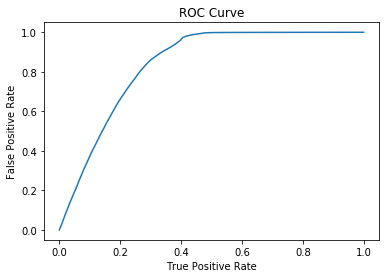

In [0]:
trainSet = fit_model_OneHot.stages[-1].summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [0]:
print('Logistic Regression TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

Logistic Regression TrainSet areaUnderROC: 0.8377495359888242

In [0]:
print("Test with OneHot Encoding", Accu_test_OneHot)
print("Train with OneHot Encoding", Accu_train_OneHot)

Test with OneHot Encoding 0.7815149625935162
Train with OneHot Encoding 0.779273041046048

###Feature Selection

In [0]:
fit_rf_Label.stages[-1].featureImportances

Out[90]: SparseVector(13, {0: 0.0004, 1: 0.0809, 2: 0.0004, 3: 0.0031, 4: 0.0002, 5: 0.3745, 6: 0.0146, 7: 0.0547, 8: 0.4091, 9: 0.0011, 10: 0.0225, 11: 0.0384, 12: 0.0})

In [0]:
input_cols_Label

Out[91]: ['genderIndex',
 'Age',
 'Driving_License',
 'regionIndex',
 'Previously_Insured',
 'Vehicle_AgeIndex',
 'Vehicle_DamageIndex',
 'Annual_Premium',
 'channelIndex',
 'Vintage']

In [0]:
data_2=fit_rf_Label.transform(train_health)

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
fit_rf_Label.stages[-1]

Out[101]: RandomForestClassificationModel: uid=RandomForestClassifier_e59af6738a0c, numTrees=200, numClasses=2, numFeatures=13

In [0]:
import pandas as pd
ExtractFeatureImp(fit_rf_Label.stages[-1].featureImportances, data_2, "features")

,idx,name,score
10,8,Vehicle_DamageVec_Yes,0.409107
2,5,Previously_Insured,0.374499
0,1,Age,0.080867
9,7,Vehicle_AgeVec_< 1 Year,0.054705
12,11,channelVec_cahnnel3,0.038401
11,10,channelVec_channel2,0.022547
8,6,Vehicle_AgeVec_1-2 Year,0.014562
6,3,regionnVec_Second,0.003143
3,9,Annual_Premium,0.001100
5,0,genderVec_Male,0.000440


In [0]:
features=ExtractFeatureImp(fit_rf_Label.stages[-1].featureImportances, data_2, "features")

features=["Vehicle_DamageVec","Previously_Insured","Vehicle_AgeVec","Age","channelVec"]
vars=features+['Response']
vars

Out[125]: ['Vehicle_DamageVec',
 'Previously_Insured',
 'Vehicle_AgeVec',
 'Age',
 'channelVec',
 'Response']

In [0]:
train_health_selected=fit_rf_Label.transform(train_health).select(vars)
test_health_selected=fit_rf_Label.transform(test_health).select(vars)

In [0]:
assembler = VectorAssembler(inputCols= features, outputCol="features")
datatrain = assembler.transform(train_health_selected)
datatest = assembler.transform(test_health_selected)

In [0]:
datatrain.select("features").show()

+--------------------+
 features|
+--------------------+
(7,[2,4,6],[1.0,2...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
[1.0,0.0,1.0,0.0,...|
(7,[3,4,6],[1.0,2...|
(7,[3,4,6],[1.0,2...|
(7,[3,4,6],[1.0,2...|
(7,[3,4,6],[1.0,2...|
+--------------------+
only showing top 20 rows

###Logistic Regression

In [0]:
log_reg_health = LogisticRegression(featuresCol='features',labelCol='Response')
fit_new = log_reg_health.fit(datatrain)

In [0]:
train_new_results = fit_new.transform(datatrain)
test_new_results = fit_new.transform(datatest)

### AUC

In [0]:
lr_train_results_auroc = evaluator.evaluate(train_new_results, {evaluator.metricName: "areaUnderROC"})
lr_test_results_auroc = evaluator.evaluate(test_new_results, {evaluator.metricName: "areaUnderROC"})

In [0]:
print("Area under ROC Curve for Train: {:.4f}".format(lr_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(lr_test_results_auroc))

Area under ROC Curve for Train: 0.8363
Area under ROC Curve for Test: 0.8392

### f1 Score

In [0]:
Accu_test_new = Accu_evaluator.evaluate(test_new_results, {Accu_evaluator.metricName: "f1"})
Accu_train_new = Accu_evaluator.evaluate(train_new_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", Accu_test_new)
print("Train with Label Encoding & feature selection", Accu_train_new)

Test with Label Encoding & feature selection 0.7754577440669579
Train with Label Encoding & feature selection 0.7731925338377963

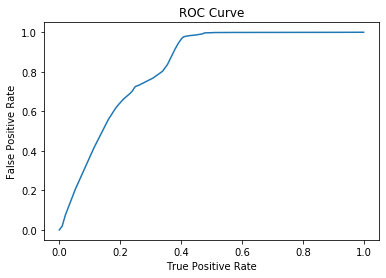

In [0]:
lr_trainSet = fit_new.summary
roc = lr_trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [0]:
print('Logistic Regression TrainSet areaUnderROC: ' + str(lr_trainSet.areaUnderROC))

Logistic Regression TrainSet areaUnderROC: 0.8244610422412632

###Random Forest

In [0]:
rf_health = RandomForestClassifier(featuresCol='features',labelCol='Response',numTrees=200)
rf_fit = rf_health.fit(datatrain)

In [0]:
rf_train_results = rf_fit.transform(datatrain)
rf_test_results = rf_fit.transform(datatest)

### AUC

In [0]:
rf_train_results_auroc = evaluator.evaluate(rf_train_results, {evaluator.metricName: "areaUnderROC"})
rf_test_results_auroc = evaluator.evaluate(rf_test_results, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve for Train: {:.4f}".format(rf_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(rf_test_results_auroc))

Area under ROC Curve for Train: 0.8411
Area under ROC Curve for Test: 0.8439

### f1 Score

In [0]:
Accu_test_new = Accu_evaluator.evaluate(rf_train_results, {Accu_evaluator.metricName: "f1"})
Accu_train_new = Accu_evaluator.evaluate(rf_test_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", Accu_test_new)
print("Train with Label Encoding & feature selection", Accu_train_new)

Test with Label Encoding & feature selection 0.7862533935853115
Train with Label Encoding & feature selection 0.7883695089169724

###Decision Tree

In [0]:
dt_health = DecisionTreeClassifier(featuresCol='features',labelCol='Response')
dt_fit = dt_health.fit(datatrain)

In [0]:
dt_train_results = dt_fit.transform(datatrain)
dt_test_results = dt_fit.transform(datatest)

### AUC

In [0]:
dt_train_results_auroc = evaluator.evaluate(dt_train_results, {evaluator.metricName: "areaUnderROC"})
dt_test_results_auroc = evaluator.evaluate(dt_test_results, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve for Train: {:.4f}".format(dt_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(dt_test_results_auroc))

Area under ROC Curve for Train: 0.8009
Area under ROC Curve for Test: 0.8035

### f1 Score

In [0]:
dt_Accu_test_new = Accu_evaluator.evaluate(dt_test_results, {Accu_evaluator.metricName: "f1"})
dt_Accu_train_new = Accu_evaluator.evaluate(dt_train_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", dt_Accu_test_new)
print("Train with Label Encoding & feature selection", dt_Accu_train_new)

Test with Label Encoding & feature selection 0.7883695089169724
Train with Label Encoding & feature selection 0.7862410179813248

###Gaint boost Tree

In [0]:
gbt_health = GBTClassifier(featuresCol='features',labelCol='Response')
rf_fit = gbt_health.fit(datatrain)

In [0]:
gbt_train_results = gbt_model.transform(train_health)
gbt_test_results = gbt_model.transform(test_health)

### AUC

In [0]:
gbt_train_results_auroc = evaluator.evaluate(gbt_train_results, {evaluator.metricName: "areaUnderROC"})
gbt_test_results_auroc = evaluator.evaluate(gbt_test_results, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve for Train: {:.4f}".format(gbt_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(gbt_test_results_auroc))

Area under ROC Curve for Train: 0.8508
Area under ROC Curve for Test: 0.8530

### f1 Score

In [0]:
gbt_Accu_test_new = Accu_evaluator.evaluate(gbt_test_results, {Accu_evaluator.metricName: "f1"})
gbt_Accu_train_new = Accu_evaluator.evaluate(gbt_train_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", gbt_Accu_test_new)
print("Train with Label Encoding & feature selection", gbt_Accu_train_new)

Test with Label Encoding & feature selection 0.792141743803668
Train with Label Encoding & feature selection 0.7907109293321513

###Naive Bayes

In [0]:
nb_health = NaiveBayes(featuresCol='features',labelCol='Response')
nb_fit = nb_health.fit(datatrain)

In [0]:
nb_train_results = nb_fit.transform(datatrain)
nb_test_results = nb_fit.transform(datatest)

### AUC

In [0]:
nb_train_results_auroc = evaluator.evaluate(nb_train_results, {evaluator.metricName: "areaUnderROC"})
nb_test_results_auroc = evaluator.evaluate(nb_test_results, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve for Train: {:.4f}".format(nb_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(nb_test_results_auroc))

Area under ROC Curve for Train: 0.8090
Area under ROC Curve for Test: 0.8112

### f1 Score

In [0]:
nb_Accu_test_new = Accu_evaluator.evaluate(nb_test_results, {Accu_evaluator.metricName: "f1"})
nb_Accu_train_new = Accu_evaluator.evaluate(nb_train_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", nb_Accu_test_new)
print("Train with Label Encoding & feature selection", nb_Accu_train_new)

Test with Label Encoding & feature selection 0.7827974252988359
Train with Label Encoding & feature selection 0.7799692934773867

###Linear SVC

In [0]:
svc_health = LinearSVC(featuresCol='features',labelCol='Response')
svc_fit = svc_health.fit(datatrain)

In [0]:
svc_train_results = svc_fit.transform(datatrain)
svc_test_results = svc_fit.transform(datatest)

### AUC

In [0]:
svc_train_results_auroc = evaluator.evaluate(svc_train_results, {evaluator.metricName: "areaUnderROC"})
svc_test_results_auroc = evaluator.evaluate(svc_test_results, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve for Train: {:.4f}".format(svc_train_results_auroc))
print("Area under ROC Curve for Test: {:.4f}".format(svc_test_results_auroc))

Area under ROC Curve for Train: 0.7892
Area under ROC Curve for Test: 0.7908

### f1 Score

In [0]:
svc_Accu_test_new = Accu_evaluator.evaluate(svc_test_results, {Accu_evaluator.metricName: "f1"})
svc_Accu_train_new = Accu_evaluator.evaluate(svc_train_results, {Accu_evaluator.metricName: "f1"})
print("Test with Label Encoding & feature selection", svc_Accu_test_new)
print("Train with Label Encoding & feature selection", svc_Accu_train_new)

Test with Label Encoding & feature selection 0.7754577440669579
Train with Label Encoding & feature selection 0.7731925338377963